In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import itertools
import numpy as np
import seaborn as sns
from scipy import interpolate
from scipy.stats import pearsonr
import os
import matplotlib.pyplot as plt
from rdkit import Chem,  DataStructs
from scipy.signal import find_peaks
import toolsets.spectra_operations as so
from toolsets.search import quick_search_values, string_search

In [2]:
spike_dir = '/Volumes/Natural Product Chemistry/Working Space/Andrea/UV Data/20230825_Spike_Exp3'

In [117]:
std_info = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Andrea/UV Data/STP000030.csv')

In [122]:
cleaned_smiles = []
for index, row in std_info.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    cleaned_smiles.append(Chem.MolToSmiles(mol))
std_info['smiles']=cleaned_smiles
std_info.drop(['SMILES'], inplace=True, axis=1)

In [77]:
lut = read_in_uv(os.path.join(spike_dir, 'Luteolin.csv'))
spike_0 = read_in_uv(os.path.join(spike_dir, 'Spike_0.csv'))
spike12 = read_in_uv(os.path.join(spike_dir, 'Spike_12.csv'))
spike25 = read_in_uv(os.path.join(spike_dir, 'Spike_25.csv'))
spike50 = read_in_uv(os.path.join(spike_dir, 'Spike_50.csv'))
spike75 = read_in_uv(os.path.join(spike_dir, 'Spike_75.csv'))
spike100 = read_in_uv(os.path.join(spike_dir, 'Spike_100.csv'))

In [199]:
spike_spec = []
conc = []
init = 0
for spike in [spike_0, spike12, spike25,spike50, spike75, spike100]:
    spike_spec.append(so.pack_spectra(spike['Wavelength'].tolist(), spike['Intensity_normalized'].tolist()))
    conc.append(init)
    init+=12.5

In [200]:
spike_df = pd.DataFrame(zip(conc, spike_spec), columns=['conc', 'uv_spec'])

In [125]:
std_info

,BSD_ID,Name,CAS,amount [mg],plate ID,position,analytical method,purity [%],PO,Collection,Novelty,Similar_V,formula,molweight,smiles
0,STD002562,NaN,NaN,1,AD236549-01,A01,HPLC ELSD,99,PO7669-2023,MEGxp,N,NP-023852,C20H20O5,340.375,CC1C(c2ccc3c(c2)OCO3)OC(c2ccc3c(c2)OCO3)C1C
1,STD002563,NaN,NaN,1,AD236549-01,A02,HPLC ELSD,96,PO7669-2023,MEGxp,N,NaN,C21H26O4,342.435,COc1ccc(CC(C)C(C)Cc2ccc3c(c2)OCO3)cc1OC
2,STD002564,NaN,NaN,1,AD236549-01,A03,NMR,70,PO7669-2023,MEGxp,N,"NP-000261, NP-005010, NP-015800; NP-019154",C20H24O5,344.407,COc1cc(C2OC(c3ccc(O)c(OC)c3)C(C)C2C)ccc1O
3,STD002565,NaN,NaN,1,AD236549-01,A04,HPLC ELSD,100,PO7669-2023,MEGxp,N,NP-012845,C20H22O4,326.392,CC(Cc1ccc2c(c1)OCO2)C(C)Cc1ccc2c(c1)OCO2
4,STD002566,Myristicin,607-91-0,1,AD236549-01,A05,NMR,70,PO7669-2023,MEGxp,N,NaN,C11H12O3,192.214,C=CCc1cc(OC)c2c(c1)OCO2
5,STD002567,NaN,NaN,1,AD236549-01,B01,HPLC ELSD,94,PO7669-2023,MEGxp,N,NaN,C14H17NO6,295.291,N#CC(OC1OC(CO)C(O)C(O)C1O)c1ccccc1
6,STD002568,Rutin,153-18-4,1,AD236549-01,B02,HPLC ELSD,100,PO7669-2023,MEGxp,N,NP-007121,C27H30O16,610.521,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...
8,STD002570,Dihydrogualaretic acid,ng,1,AD236549-01,B04,HPLC ELSD,88,PO7669-2023,MEGxp,N,NP-004155,C20H26O4,330.424,COc1cc(CC(C)C(C)Cc2ccc(O)c(OC)c2)ccc1O
9,STD002571,NaN,NaN,1,AD236549-01,C01,HPLC ELSD,100,PO7669-2023,MEGxp,N,NP-013791,C20H24O4,328.408,COc1cc(CC(C)C(C)Cc2ccc3c(c2)OCO3)ccc1O
10,STD002572,Catechin,154-23-4,1,AD236549-01,C02,HPLC ELSD,99,PO7669-2023,MEGxp,N,NaN,C15H14O6,290.271,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@@H](O)C2


In [147]:
std_dir = '/Volumes/Natural Product Chemistry/Working Space/Andrea/UV Data/STP000030'
from scipy.stats import pearsonr
from toolsets.file_io import get_file_list
# file_list = get_file_list(std_dir, 'csv')
file_list = []
for index, row in std_info.iterrows():
    if os.path.exists(os.path.join(std_dir, row['BSD_ID']+'_P.csv')):
        file_list.append(row['BSD_ID'])
cmb = itertools.combinations(file_list, 2)
corr = []
std_0 = []
std_1 = []
smile_0 = []
smile_1 = []
tanimoto = []
for c in cmb:
    # print('i am in loop')
    std_0.append(c[0])
    std_1.append(c[1])
    smile_0_temp = string_search(std_info, 'BSD_ID', c[0]).iloc[0]['smiles']
    smile_1_temp = string_search(std_info, 'BSD_ID', c[1]).iloc[0]['smiles']
    smile_0.append(smile_0_temp)
    smile_1.append(smile_1_temp)
    fp0 = Chem.RDKFingerprint(Chem.MolFromSmiles(smile_0_temp))
    fp1 = Chem.RDKFingerprint(Chem.MolFromSmiles(smile_1_temp))
    std1 = read_in_uv(os.path.join(std_dir, c[0]+'_P.csv'))
    std2 = read_in_uv(os.path.join(std_dir, c[1]+'_P.csv'))
    tanimoto.append(DataStructs.TanimotoSimilarity(fp0,fp1))
    corr.append(pearsonr(std1['Intensity_normalized'] , std2['Intensity_normalized'])[0])
corr_df = pd.DataFrame(zip(std_0, std_1, corr,tanimoto, smile_0, smile_1), columns=['std_0', 'std_1', 'correlation','tanimoto','smile_0', 'smile_1'])
corr_df.sort_values(by = 'correlation', ascending=False, inplace=True)

In [179]:
uv_lib = pd.DataFrame()
smile = []
brd_id = []
uv_spec  = []
for f in file_list:
    brd_id.append(f)
    uv_temp = read_in_uv(os.path.join(std_dir, f+'_P.csv'))
    uv_spec.append(so.pack_spectra(uv_temp['Wavelength'].tolist(), uv_temp['Intensity_normalized'].tolist()))
    smile.append(string_search(std_info, 'BSD_ID', f).iloc[0]['smiles'])
    # print(f)

In [187]:
uv_lib = pd.DataFrame(zip(brd_id, smile, uv_spec), columns=['BRD_ID', 'smile', 'uv_spec'])

In [214]:
spike_df

,conc,uv_spec
0,0.0,190\t0.35141543951390775\n200\t0.3651266618978...
1,12.5,190\t0.3364425447177755\n200\t0.37855340037096...
2,25.0,190\t0.43916663160682157\n200\t0.3969661272400...
3,37.5,190\t0.360516873569054\n200\t0.398450550898963...
4,50.0,190\t0.3151624542595015\n200\t0.39412871474090...
5,62.5,190\t0.43711098641106527\n200\t0.3644625090997...


In [ ]:
from toolsets.flash_entropy_helper import flash_entropy_simple

In [227]:
entropy = []
for index, row in uv_lib.iterrows():
    spec_1_nor = so.normalize_spectrum(spike_df.iloc[0]['uv_spec'])
    spec_2_nor = so.normalize_spectrum(row['uv_spec'])
    entropy.append(flash_entropy_simple( spec_1_nor ,spec_2_nor , pmz=681))
uv_lib_result = uv_lib.copy()
uv_lib_result['entropy']=entropy
uv_lib_result.sort_values(by = 'entropy', ascending=False, inplace=True)
uv_lib_result

,BRD_ID,smile,uv_spec,entropy
25,Luteolin,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,190\t0.2040829659184522\n200\t0.37073024603916...,0.998656
13,STD002579,O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,190\t0.396890059678174\n200\t0.439859573540116...,0.992598
16,STD002583,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,190\t0.3580451499554151\n200\t0.39028666778496...,0.990970
18,STD002587,O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,190\t0.18607650597498274\n200\t0.2689760221045...,0.977538
5,STD002568,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,190\t0.19452779591947295\n200\t0.2490550672943...,0.975695
9,STD002573,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,190\t0.18618022670051246\n200\t0.2826660377475...,0.944257
24,STD002594,O=C(O)/C=C/c1ccc(O)c(O)c1,190\t0.21054625657957052\n200\t0.2673626884146...,0.914212
12,STD002577,OC[C@@]1(O)CO[C@@H](OC[C@H]2O[C@@H](OCc3ccccc3...,190\t0.08262974834617745\n200\t0.1664256973334...,0.881871
15,STD002582,C=CCc1cc(OC)c(OC)c(OC)c1,190\t0.26265664519093995\n200\t0.2061995755741...,0.864108
21,STD002590,O=C(O)/C=C/c1ccc(O)cc1,190\t0.1473339963444024\n200\t0.15311988562345...,0.814910


In [228]:
entropy = []
for index, row in uv_lib.iterrows():
    spec_1_nor = so.normalize_spectrum(spike_df.iloc[2]['uv_spec'])
    spec_2_nor = so.normalize_spectrum(row['uv_spec'])
    entropy.append(flash_entropy_simple( spec_1_nor ,spec_2_nor , pmz=681))
uv_lib_result = uv_lib.copy()
uv_lib_result['entropy']=entropy
uv_lib_result.sort_values(by = 'entropy', ascending=False, inplace=True)
uv_lib_result

,BRD_ID,smile,uv_spec,entropy
25,Luteolin,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,190\t0.2040829659184522\n200\t0.37073024603916...,0.990767
13,STD002579,O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,190\t0.396890059678174\n200\t0.439859573540116...,0.990767
16,STD002583,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,190\t0.3580451499554151\n200\t0.39028666778496...,0.988909
18,STD002587,O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,190\t0.18607650597498274\n200\t0.2689760221045...,0.973690
5,STD002568,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,190\t0.19452779591947295\n200\t0.2490550672943...,0.971262
9,STD002573,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,190\t0.18618022670051246\n200\t0.2826660377475...,0.939819
24,STD002594,O=C(O)/C=C/c1ccc(O)c(O)c1,190\t0.21054625657957052\n200\t0.2673626884146...,0.912019
12,STD002577,OC[C@@]1(O)CO[C@@H](OC[C@H]2O[C@@H](OCc3ccccc3...,190\t0.08262974834617745\n200\t0.1664256973334...,0.891706
15,STD002582,C=CCc1cc(OC)c(OC)c(OC)c1,190\t0.26265664519093995\n200\t0.2061995755741...,0.889852
10,STD002574,O=C(O)c1ccc(O)c(O)c1,190\t0.3288033520799146\n200\t0.36218531575964...,0.825681


In [232]:
flash_entropy_simple(spec_2_nor, spec_1_nor, pmz = 681)

0.9921387

In [260]:
score = []

for index, row in uv_lib.iterrows():
    score.append(temp_score( spike_df.iloc[0]['uv_spec'] ,row['uv_spec'] ))
uv_lib_result = uv_lib.copy()
uv_lib_result['score']=score
uv_lib_result.sort_values(by = 'score', ascending=False, inplace=True)
uv_lib_result

,BRD_ID,smile,uv_spec,score
25,Luteolin,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,190\t0.2040829659184522\n200\t0.37073024603916...,0.971963
13,STD002579,O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,190\t0.396890059678174\n200\t0.439859573540116...,0.834021
16,STD002583,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,190\t0.3580451499554151\n200\t0.39028666778496...,0.818549
18,STD002587,O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,190\t0.18607650597498274\n200\t0.2689760221045...,0.740521
5,STD002568,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,190\t0.19452779591947295\n200\t0.2490550672943...,0.729964
9,STD002573,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,190\t0.18618022670051246\n200\t0.2826660377475...,0.601281
24,STD002594,O=C(O)/C=C/c1ccc(O)c(O)c1,190\t0.21054625657957052\n200\t0.2673626884146...,0.431426
12,STD002577,OC[C@@]1(O)CO[C@@H](OC[C@H]2O[C@@H](OCc3ccccc3...,190\t0.08262974834617745\n200\t0.1664256973334...,0.310093
15,STD002582,C=CCc1cc(OC)c(OC)c(OC)c1,190\t0.26265664519093995\n200\t0.2061995755741...,0.309906
10,STD002574,O=C(O)c1ccc(O)c(O)c1,190\t0.3288033520799146\n200\t0.36218531575964...,0.223888


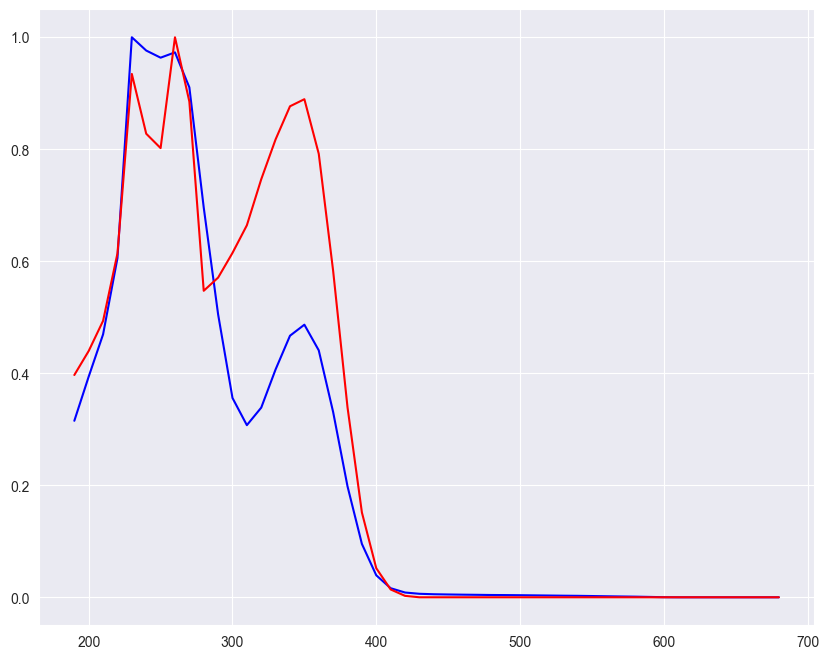

In [259]:
uv_stack_std(spike_df.iloc[4]['uv_spec'], uv_lib_result.iloc[0]['uv_spec'])

In [247]:
temp_score(spike_df.iloc[2]['uv_spec'], spike_df.iloc[1]['uv_spec'])

0.91644168

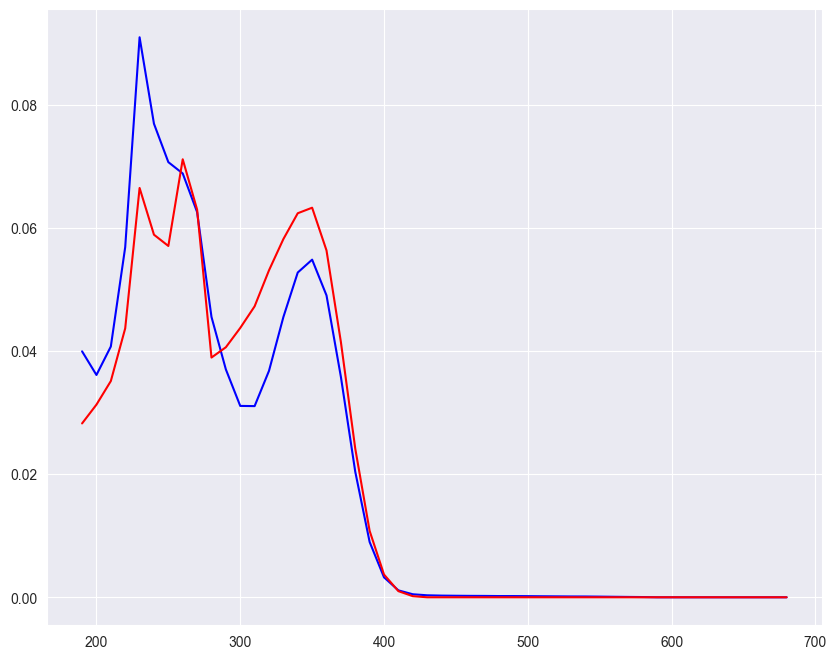

In [233]:
# spec_1_nor = so.normalize_spectrum(uv_lib_result.iloc[0]['uv_spec'])
spec_1_nor = so.normalize_spectrum(spike_df.iloc[2]['uv_spec'])

spec_2_nor = so.normalize_spectrum(uv_lib_result.iloc[1]['uv_spec'])
uv_stack_std(spec_1_nor, spec_2_nor)

In [180]:
from toolsets.API_gets import name_to_smiles

In [159]:
corr_df.sort_values(by = 'tanimoto', ascending=False)

,std_0,std_1,correlation,tanimoto,smile_0,smile_1
72,STD002565,STD002571,0.988522,1.000000,CC(Cc1ccc2c(c1)OCO2)C(C)Cc1ccc2c(c1)OCO2,COc1cc(CC(C)C(C)Cc2ccc3c(c2)OCO3)ccc1O
220,STD002576,STD002593,0.981306,0.996633,C=CCc1cc(OC)c(OC(C)C(O)c2cc(OC)c(OC)c(OC)c2)c(...,C=CCc1cc(OC)c(OC(C)C(O)c2ccc(O)c(OC)c2)c(OC)c1
29,STD002563,STD002571,0.978568,0.986523,COc1ccc(CC(C)C(C)Cc2ccc3c(c2)OCO3)cc1OC,COc1cc(CC(C)C(C)Cc2ccc3c(c2)OCO3)ccc1O
25,STD002563,STD002565,0.956204,0.986523,COc1ccc(CC(C)C(C)Cc2ccc3c(c2)OCO3)cc1OC,CC(Cc1ccc2c(c1)OCO2)C(C)Cc1ccc2c(c1)OCO2
122,STD002568,STD002587,0.999676,0.980183,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...
...,...,...,...,...,...,...
191,STD002573,STD002590,0.336123,0.103594,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,O=C(O)/C=C/c1ccc(O)cc1
268,STD002583,STD002590,0.625528,0.097671,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,O=C(O)/C=C/c1ccc(O)cc1
241,STD002579,STD002590,0.623766,0.097393,O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,O=C(O)/C=C/c1ccc(O)cc1
125,STD002568,STD002590,0.499646,0.095729,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,O=C(O)/C=C/c1ccc(O)cc1


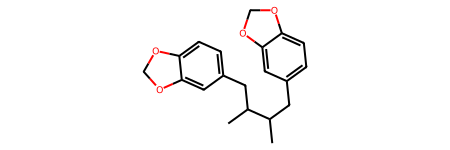

In [160]:
Chem.MolFromSmiles(corr_df.loc[72]['smile_0'])

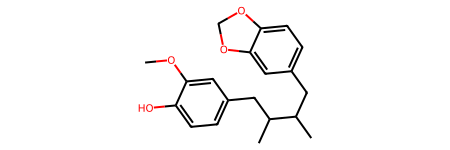

In [161]:
Chem.MolFromSmiles(corr_df.loc[72]['smile_1'])

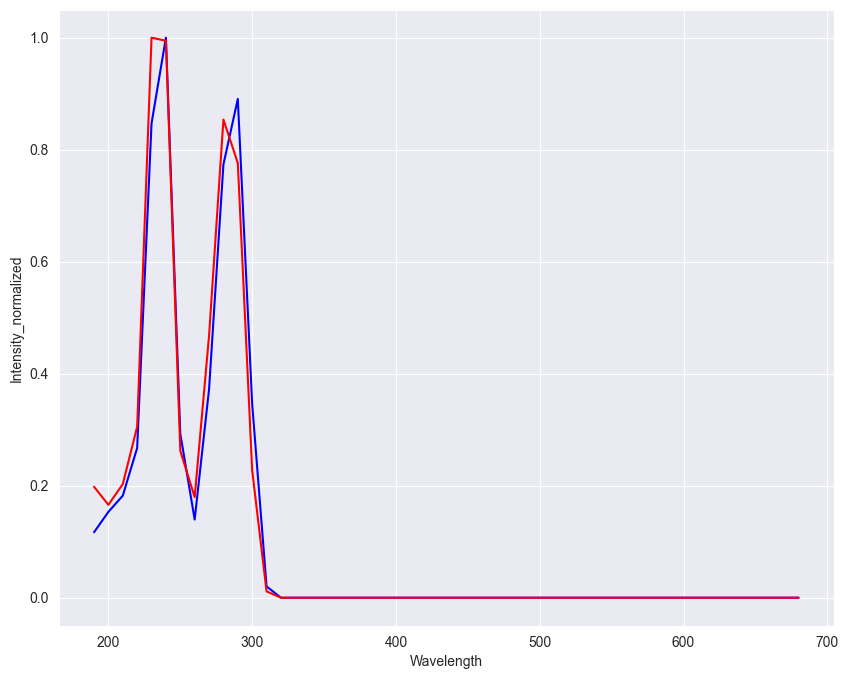

In [162]:
std0 =read_in_uv(os.path.join(std_dir, corr_df.loc[72]['std_0']+"_P.csv"))
std1 =read_in_uv(os.path.join(std_dir, corr_df.loc[72]['std_1']+"_P.csv"))
uv_stack(std0, std1)

In [87]:
from toolsets.ff_droup import get_peaks

In [113]:
std_dir

'/Volumes/Natural Product Chemistry/Working Space/Andrea/UV Data/STP000030'

In [88]:
peaks =get_peaks(spike100['Intensity_normalized'])

In [95]:
std1 = read_in_uv(os.path.join(std_dir, file_list[0]+'.csv'))

In [102]:
from scipy.signal import find_peaks

In [103]:
apex, _ = find_peaks(std1['Intensity_normalized'])

In [111]:
apex0, _ = find_peaks(temp0['Intensity_normalized'])
apex1, _ = find_peaks(temp1['Intensity_normalized'])

In [112]:
for apex in apex0:
    apex_diff = [abs(x - apex) for x in ]

array([ 5, 10])

In [114]:
corr_df

,std_0,std_1,correlation
0,STD002562_P,STD002563_P,0.986089
1,STD002562_P,STD002564_P,0.943804
2,STD002562_P,STD002565_P,0.984251
3,STD002562_P,STD002566_P,0.898300
4,STD002562_P,STD002568_P,0.449751
...,...,...,...
401,STD002590_P,STD002593_P,0.265259
402,STD002590_P,STD002594_P,0.906268
403,STD002591_P,STD002593_P,0.972336
404,STD002591_P,STD002594_P,0.408711


In [115]:
temp0 = read_in_uv(os.path.join(std_dir, 'STD002562_P'+'.csv'))
temp1 = read_in_uv(os.path.join(std_dir, 'STD002563_P'+'.csv'))

In [22]:
corr = []
for d in [spike_0,spike12, spike25, spike50, spike75, spike100]:
    corr.append(scipy.stats.pearsonr(d['Intensity'] , lut['Intensity'])[0])

<Axes: >

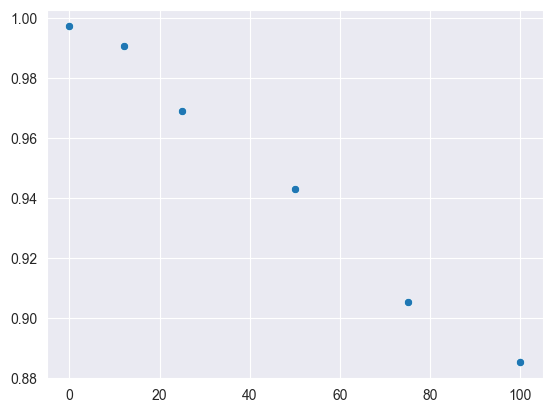

In [23]:
sns.scatterplot(x = [0,12,25,50,75,100], y = corr)


In [55]:
corr_df

,std_0,std_1,correlation
0,STD002562_P,STD002563_P,0.986213
1,STD002562_P,STD002564_P,0.944404
2,STD002562_P,STD002565_P,0.984375
3,STD002562_P,STD002566_P,0.899969
4,STD002562_P,STD002568_P,0.452344
...,...,...,...
401,STD002590_P,STD002593_P,0.268340
402,STD002590_P,STD002594_P,0.906470
403,STD002591_P,STD002593_P,0.972469
404,STD002591_P,STD002594_P,0.414760


In [50]:
temp0 = pd.read_csv(os.path.join(std_dir, 'STD002562_P'+'.csv'), header=6)
temp1 = pd.read_csv(os.path.join(std_dir, 'STD002563_P'+'.csv'), header=6)

<Axes: xlabel='Wavelength', ylabel='Intensity'>

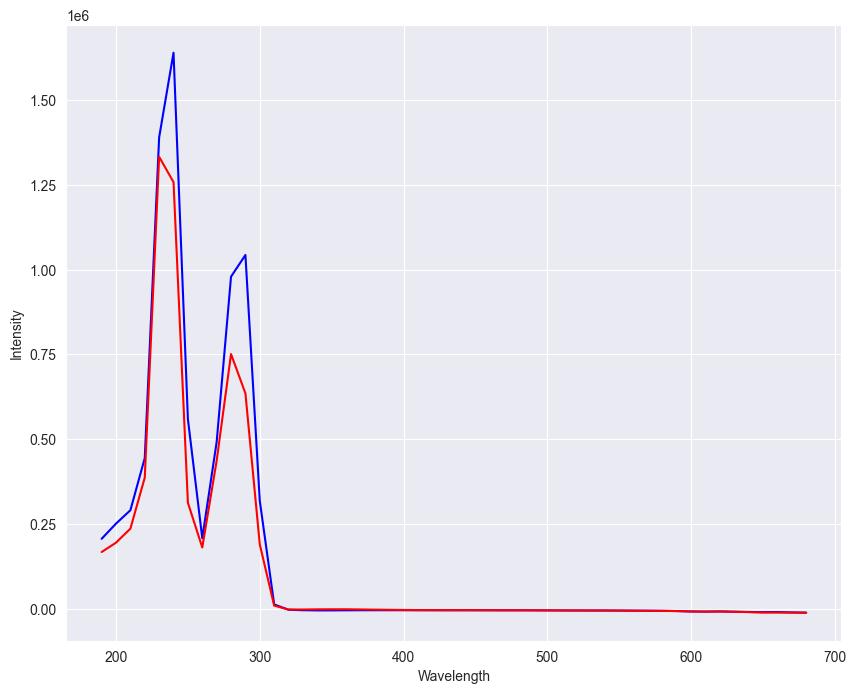

In [51]:
fig = plt.figure(figsize = (10, 8))#43
plt.subplots_adjust()
ax = fig.add_subplot()
sns.lineplot(x = temp0['Wavelength'], y = temp0['Intensity'], color='blue')
sns.lineplot(x = temp1['Wavelength'], y = temp1['Intensity'], color='red')

<Axes: xlabel='Wavelength', ylabel='Intensity'>

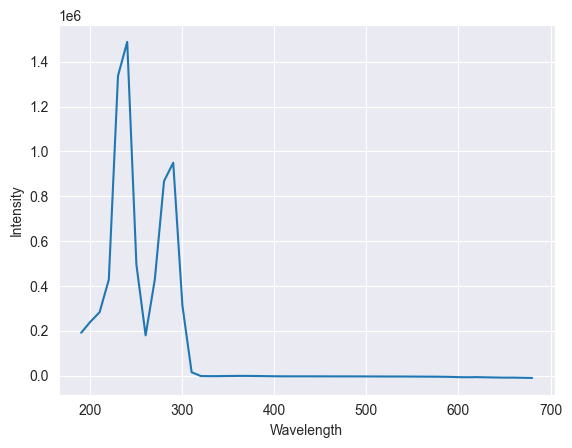